In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.applications import VGG16
from tensorflow.keras import layers, Sequential

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, ReLU

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

2024-05-19 23:46:16.158960: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-19 23:46:16.159096: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-19 23:46:16.418785: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
img_height=224
img_width=224
BATCH_SIZE = 60
NUM_EPOCHS = 30

In [4]:
df_aug = pd.read_csv('/kaggle/input/signals-dataset/Scalogram_grayscale_augumented_images.csv')
df_aug = df_aug.drop('Unnamed: 0', axis=1)

In [5]:
df_aug = df_aug[df_aug['Label'] != 'The functional activity of the central and peripheral parts of the retina in both eyes is preserved.'].reset_index(drop=True)
df_aug.groupby(['Label']).count()

,img_Path,img_id
Label,,
0,1380,1380
1,1284,1284


In [6]:
img_Path = []
for i in range (len(df_aug.img_id)):
    if i < 2220:
        img_Path.append(f'/kaggle/input/signals-dataset/augmented_images/{df_aug.img_id[i]}.png')
    else :    
        img_Path.append(f'/kaggle/input/signals-dataset/signals/{df_aug.img_id[i]}.png')
df_aug['img_Path']=img_Path        

In [7]:
image_train, image_test, label_train, label_test = train_test_split(df_aug.img_Path, df_aug.Label, test_size=0.2, random_state=42,stratify=df_aug['Label'])
image_valid, image_Test, label_valid, label_Test = train_test_split(image_test, label_test, test_size=0.5, random_state=42,stratify=label_test)

In [8]:
train_df_aug = pd.DataFrame({'image_id': image_train, 'label': label_train}).reset_index(drop=True)
valid_df_aug = pd.DataFrame({'image_id': image_valid, 'label': label_valid}).reset_index(drop=True)
test_df_aug = pd.DataFrame({'image_id': image_Test, 'label': label_Test}).reset_index(drop=True)

In [9]:
print(train_df_aug.groupby(['label']).count())
print(valid_df_aug.groupby(['label']).count())
print(test_df_aug.groupby(['label']).count())

       image_id
label          
0          1104
1          1027
       image_id
label          
0           138
1           128
       image_id
label          
0           138
1           129


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(rescale=1./255.).flow_from_dataframe(
    dataframe=train_df_aug,
    directory='/kaggle/input/signals-dataset',
    x_col='image_id',  # this column contains the filenames
    y_col='label',  # this column contains the class labels
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
valid_generator = ImageDataGenerator(rescale=1./255.).flow_from_dataframe(
    dataframe=valid_df_aug,
    directory='/kaggle/input/signals-dataset',
    x_col='image_id',  
    y_col='label',  
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
test_generator = ImageDataGenerator(rescale=1./255.).flow_from_dataframe(
    dataframe=test_df_aug,
    directory='/kaggle/input/signals-dataset',
    x_col='image_id',  
    y_col='label',  
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 2131 validated image filenames belonging to 2 classes.
Found 266 validated image filenames belonging to 2 classes.
Found 267 validated image filenames belonging to 2 classes.


## CNN Network

##  VGG16

In [11]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = tf.keras.layers.Dense(512, activation='relu')(x)

# Add a final softmax layer for classification
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

# Freeze the layers in base_model
for layer in base_model.layers:
    layer.trainable = False
    
model.summary()    

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,560,769 (105.14 MB)

 Trainable params: 12,846,081 (49.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
# Compile the model
learning_rate = 0.001
model.compile(optimizer=Adam(learning_rate),loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])

In [13]:
# Defining early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'auto',    
    min_delta = 0,
    patience = 4,
    verbose = 0, 
    restore_best_weights = True
)

In [14]:
# Train the network
model_1 = model.fit(
        train_generator, 
        epochs = NUM_EPOCHS, 
        callbacks = [early_stopping], 
        validation_data = valid_generator,
        verbose = 2   
    )

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1716162523.353066     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716162523.374708     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716162564.009799     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716162575.497107     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716162602.388263     105 graph_launch.cc:671] Fallback to op-by-op mode because mems

36/36 - 140s - 4s/step - binary_accuracy: 0.5321 - loss: 1.8014 - val_binary_accuracy: 0.6015 - val_loss: 0.6669
Epoch 2/30
36/36 - 19s - 529ms/step - binary_accuracy: 0.6584 - loss: 0.6129 - val_binary_accuracy: 0.5677 - val_loss: 0.7100
Epoch 3/30
36/36 - 19s - 535ms/step - binary_accuracy: 0.7034 - loss: 0.5559 - val_binary_accuracy: 0.6692 - val_loss: 0.6113
Epoch 4/30
36/36 - 19s - 537ms/step - binary_accuracy: 0.7433 - loss: 0.5087 - val_binary_accuracy: 0.6692 - val_loss: 0.6170
Epoch 5/30
36/36 - 20s - 545ms/step - binary_accuracy: 0.7654 - loss: 0.4850 - val_binary_accuracy: 0.5977 - val_loss: 0.7125
Epoch 6/30
36/36 - 19s - 537ms/step - binary_accuracy: 0.8268 - loss: 0.4038 - val_binary_accuracy: 0.6805 - val_loss: 0.6163
Epoch 7/30
36/36 - 19s - 541ms/step - binary_accuracy: 0.8583 - loss: 0.3604 - val_binary_accuracy: 0.6955 - val_loss: 0.5881
Epoch 8/30
36/36 - 19s - 529ms/step - binary_accuracy: 0.8724 - loss: 0.3291 - val_binary_accuracy: 0.6842 - val_loss: 0.6036
Epoch

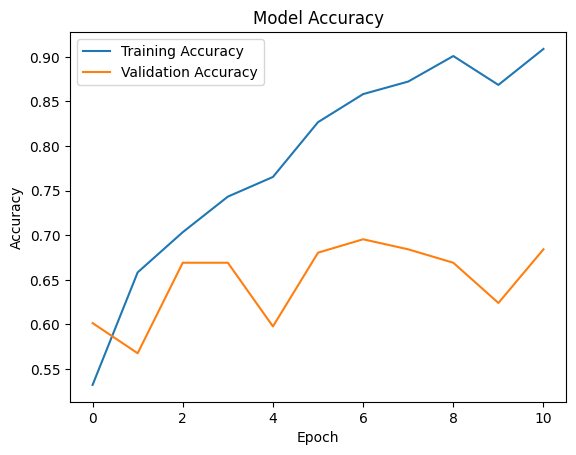

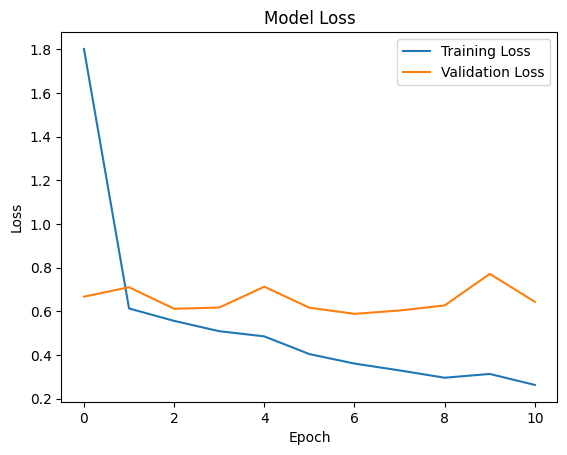

In [15]:
# Plot training and validation accuracy
plt.plot(model_1.history['binary_accuracy'], label='Training Accuracy')
plt.plot(model_1.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(model_1.history['loss'], label='Training Loss')
plt.plot(model_1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
y_pred_ = model.predict(test_generator)

5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 7s/step 


In [33]:
threshold = 0.58
y_pred = (y_pred_[:] > threshold).astype(int)  # Convert to binary predictions
y_true = np.array(test_df_aug.label,int)

In [53]:
#y_pred = np.round(y_pred_).flatten()

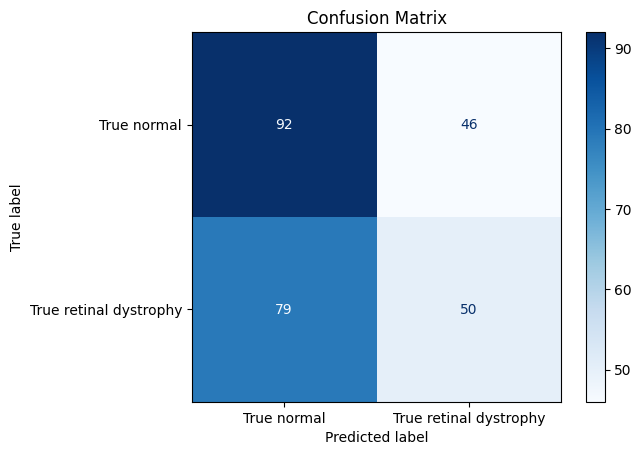

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 344ms/step - binary_accuracy: 0.7421 - loss: 0.5442


0.7340824007987976

In [34]:
cm = confusion_matrix(y_true, y_pred)
# Plot confusion matrix
labels = ['normal', 'retinal dystrophy']  
display_labels = ['True ' + label for label in labels]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

model.evaluate(test_generator)[1]

In [35]:
print(classification_report(y_true, y_pred, target_names=['normal', 'retinal dystrophy']))

                   precision    recall  f1-score   support

           normal       0.54      0.67      0.60       138
retinal dystrophy       0.52      0.39      0.44       129

         accuracy                           0.53       267
        macro avg       0.53      0.53      0.52       267
     weighted avg       0.53      0.53      0.52       267



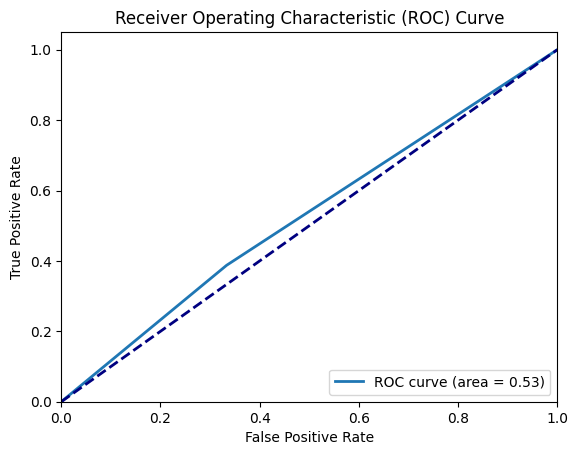

In [36]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_true, y_pred)

# Calculate area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [37]:
model.save('vgg16.h5')